In [1]:
from jenkspy import JenksNaturalBreaks
import pandas as pd
import numpy as np
import time
import os
import pickle
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

### Helper Functions

In [2]:
def loadPickle(path):
    out = pickle.load(open(path, 'rb'))
    return out

def writePickle(path, object):
    pickle_out = open(path, "wb")
    pickle.dump(object, pickle_out)
    pickle_out.close()

def get_y(data, groups=["card"]):
    y1 = data.groupby(groups).aggregate({'tmsp': 'count'}).rename(columns={'tmsp': 'count'}).reset_index()
    y2 = data[data["success"] == 1].groupby(groups).aggregate({'tmsp': 'count'}).rename(columns={"tmsp": "count_success"}).reset_index()
    
    y = y1.merge(y2, on = groups)
    y["success_rate"] = y['count_success']/y['count']
    
    return y

def generateDataFromFile():
    if (
        (os.path.isfile('./data/X_train.csv')) & (os.path.isfile('./data/X_test.csv')) & 
        (os.path.isfile('./data/y_train.csv')) & (os.path.isfile('./data/y_test.csv')) &
        (os.path.isfile('./data/y_validate.csv')) & (os.path.isfile('./data/X_validate.csv'))
    ):
        print("generate from files")
        X_train = pd.read_csv('./data/X_train.csv', index_col = 'index')
        X_train.index.name = None
        X_test = pd.read_csv('./data/X_test.csv', index_col = 'index')
        X_test.index.name = None
        X_validate = pd.read_csv('./data/X_validate.csv', index_col = 'index')
        X_validate.index.name = None
        y_train = pd.read_csv('./data/y_train.csv', index_col = 'index')
        y_train.index.name = None
        y_test = pd.read_csv('./data/y_test.csv', index_col = 'index')
        y_test.index.name = None
        y_validate = pd.read_csv('./data/y_validate.csv', index_col = 'index')
        y_validate.index.name = None
        
        print("=== all data loaded from files ===")
        
        return (X_train, y_train, X_validate, y_validate, X_test, y_test)
    else:
        print("skip the step because not all data is prepared yet")
        
        return (None, None, None, None, None, None)

def saveSplittings(X, y, X_train, y_train, X_validate, y_validate, X_test, y_test):
    if (
            (not os.path.isfile('./data/X_train.csv')) & (not os.path.isfile('./data/X_test.csv')) &
            (not os.path.isfile('./data/y_train.csv')) & (not os.path.isfile('./data/y_test.csv')) &
            (not os.path.isfile('./data/X_validate.csv')) & (not os.path.isfile('./data/y_validate.csv'))
        ):
        X_train.to_csv('./data/X_train.csv', index = True, index_label = 'index')
        X_test.to_csv('./data/X_test.csv', index = True, index_label = 'index')
        y_train.to_csv('./data/y_train.csv', index = True, index_label = 'index')
        y_test.to_csv('./data/y_test.csv', index = True, index_label = 'index')
        X_validate.to_csv('./data/X_validate.csv', index = True, index_label='index')
        y_validate.to_csv('./data/y_validate.csv', index = True, index_label='index')
        X.to_csv('./data/X.csv', index = True, index_label = 'index')
        y.to_csv('./data/y.csv', index = True, index_label = 'index')
    else:
        print("nothing to write")

# Data Preparation

According to IBM corporation (2013) the data preparation process can be outlined as follows (p. 18):

The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection, data cleaning, construction of new attributes, and transformation of data for modeling tools.

Data preparation is one of the most important and often time-consuming aspects of data mining. In fact, it is estimated that data preparation usually takes 50-70% of a project's time and effort. Devoting adequate energy to the earlier business understanding and data understanding phases can minimize this overhead, but you still need to expend a good amount of effort preparing and packaging the data for mining. Depending on your organization and its goals, data preparation typically involves the following tasks: 
* Merging data sets and/or records 
* Selecting a sample subset of data
* Aggregating records 
* Deriving new attributes 
* Sorting the data for modeling 
* Removing or replacing blank or missing values 
* Splitting into training and test data sets

## Select Data

The data selection phase contains the selection of rows and columns which are necessary for the further modeling process. For the case-study it is first of all important to address the given insights from the business side and keep only distinct purchases in the dataset. This means we have to remove all transactions where customers tried several times to transfer the money. If two transactions are within one minute, with the same amount of money and from the same country, it is (for a decent number of tries) safe to assume that they are payment attempts of the same purchase. This means we have to remove those unsuccessful transactions from the dataset, who meat the previously stated equality-criteria from business side.

### Rows

In [3]:
def getNumUpper(timestamp, lower, upper, amount, country, testdata):
    selecteddata = testdata[
        (testdata['amount'] == amount) & 
        (testdata['country'] == country) &
        (testdata['tmsp'] > timestamp) &
        (testdata['tmsp'] <= upper)
    ]
    
    return len(selecteddata)

def getLowerFailedPSP(row, woUpper, inFrame):
    if (woUpper.index.get_loc(row.name) == 0):
        locPrev = inFrame.iloc[0, :].name
    else:
        ilocPrev = woUpper.index.get_loc(row.name) - 1
        locPrev = woUpper.iloc[ilocPrev, :].name
    
    locAct = row.name
    
    selection = inFrame.loc[locPrev:locAct]
    selection = selection[
        (selection.numUpper > 0) &
        (selection.amount == row.amount) &
        (selection.country == row.country)
    ]
    if len(selection) > 0:
        failedPSP = sorted(list(selection["PSP"].unique()))
        returnDummy = []
        for psp in sorted(inFrame["PSP"].unique()):
            if any(psp in s for s in failedPSP):
                returnDummy.append(1)
            else:
                returnDummy.append(0)
        return [1, failedPSP, returnDummy[0], returnDummy[1], returnDummy[2], returnDummy[3]]
    else:
        return [0, [], 0, 0, 0, 0]

def selectRows(data):
    start_time = time.time()
    out = data.copy()
    out["lower"] = out["tmsp"] + pd.Timedelta(minutes=-1)
    out["upper"] = out["tmsp"] + pd.Timedelta(minutes=1)
    
    out['numUpper'] = out.apply(lambda row : getNumUpper(
        row['tmsp'],
        row['lower'],
        row['upper'],
        row['amount'],
        row['country'],
        testdata = out
    ), axis = 1)
    out = out.copy().sort_values(by=['tmsp'])
    woUpper = out[out['numUpper'] == 0]
    print("= Half time: " + str(time.time() - start_time) + " seconds")
    out = out.join(
        woUpper.apply(lambda row : getLowerFailedPSP(
            row, 
            woUpper.copy(), 
            out.copy()
        ), axis = 1, result_type = 'expand').rename(columns={
            0: "failPrevious",
            1: "failedPSP",
            2: "failed_Goldcard",
            3: "failed_Moneycard",
            4: "failed_Simplecard",
            5: "failed_UK_Card"
        })
    )[out["numUpper"] == 0]
    print("= End Time: " + str(time.time() - start_time) + " seconds")
    
    return out

### Columnms

In [4]:
def dropColumns(data, columns = ['tmsp', 'daytime', 'time', 'failedPSP', 'amountgroup', 'amountgroup_word', 'lower', 'upper', 'numUpper']):
    out = data.copy()
    if len(set(columns).intersection(set(out.columns))) > 0:
        out = out.drop(columns, axis = 1)
    
    return out

### Feature selection
Because CRISP-DM is a cyclic process we reference to a subsequent process back namely the formatting step. <br>
In this step we first have to load the needed and splitted data.

In terms of feature importance it is almost anytime important to remove redundant features which are highly correlated with each other. We have binary variables and continuous variables in the dataset. For the correlation of two continuous variables the correlation is calculated based on the Pearson correlation coefficient, for two binary variables it is the Phi-coefficient and for a binary and a continuous variable it is the point biseral correlation. The Phi-coefficient and the point biseral correlation are both special cases of the Pearson correlation. Hence, for all feature constellations in the dataset we can calculate the Pearson correlation coefficient in order to remove redundant features. Kuhn and Johnson (2013, p. 47) propose a pairwise between-predictor correlation of less than 0.75 for models that are particularly sensitive to multicollinearity. In order to find those predictors Kuhn and Johnson propose the following algorithm:
* Calculate the correlation matrix of the predictors
* Determine the two predictors associated with the largest absolute pairwise correlation (A and B)
* Determine the average correlation between A and the other variables. Do the same for predictor B.
* If A has a larger average correlation, remove it, otherwise remove B.
* Repeat the steps until no absolute correlations are above the threshold.

The algorithm is applied in the function ```correlationFiltering(X_train, threshold = 0.75)```. There are no predictors in the dataset with a higher pairwise correlation than 0.75.

Because it is unclear at this point, if the final model will be tree-based, linear or a deep neural network architecture a model-based wrapper feature selection is implemented called ```recursive feature elimination```. According to Kuhn & Johnson (2019) it is, at least for tree-based modeling approaches recommended to do a correlation based feature selection first. Features with redundant information have already been removed from the dataset (see below). In this step the features will be selected based on training data with a fixed validation dataset.

In [5]:
def correlationFiltering(X_train, threshold = 0.75, figsize = 10):
    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(X_train.corr().round(2), annot=False)
    plt.show()
    
    # create correlation matrix
    corrMatrix = X_train.corr().abs()
    # get upper triangle
    upperCorrMatrix = corrMatrix.where(
        np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool_))
    uniqueCorrPairs = upperCorrMatrix.unstack().dropna()
    sortedCorrPairs = uniqueCorrPairs.sort_values(ascending = False)
    # identify all paird with correlation greater than threshold
    pairsToFilter = sortedCorrPairs[sortedCorrPairs > threshold]
    toRemove = []
    for pair in pairsToFilter.index:
        # calculate average correlation between A and other variables and B with other variables
        a = pair[0]
        a_avg = corrMatrix[a].mean()
        b = pair[1]
        b_avg = corrMatrix[b].mean()
        # if A has a larger average correlation, remove it, otherwise remove B
        if a_avg > b_avg:
            toRemove.append(a)
        else:
            toRemove.append(b)

    return list(set(toRemove))

In [6]:
def RFECV_ranking(
                    X_train, y_train, X_validate, y_validate, 
                    metrics = ["roc_auc", "precision", "recall"], 
                    folds = 3,
                    step = 2,
                    estimator = RandomForestClassifier(n_estimators=500, random_state=1977)
                 ):
    X = pd.concat([X_train, X_validate])
    y = pd.concat([y_train, y_validate]).values.ravel()
    
    train_indices = list(range(len(X_train)))
    test_indices = list(range(len(X_train), len(X)))
    
    cv = [(train_indices, test_indices)]
    importantFeatures = {}
    
    for metric in metrics:
        print("=== " + metric + " ===")
        rfecv = RFECV(estimator=estimator, step=step, cv=cv, scoring=metric, verbose=3)
        rfecv.fit(X,y)
        print('Optimal number of features: {}'.format(rfecv.n_features_))
        try:
            plt.figure(figsize=(16, 9))
            plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
            plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
            plt.ylabel('Mean ' + metric, fontsize=14, labelpad=20)
            plt.ylim(0, 1)
            plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)
            plt.show()
        except:
            print("=== There was somewhere an Error ===")

        features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]
        print("= Features:")
        print(features)
        print("= Maximum Test Score:")
        print(rfecv.cv_results_['mean_test_score'].max())
        
        writePickle(path = "./data/rfecv_" + metric + ".pkl", object = rfecv)
        print("=== rfecv_" + metric + " saved to pickle file ===")
        print("")
        
        importantFeatures[metric] = features
        
    return importantFeatures

In [7]:
def applyFeatureSelection(
        metrics = ["roc_auc", "precision", "recall"],
        estimator = RandomForestClassifier(n_estimators=250, random_state=1977),
        correlation_threshold = 0.75,
        step = 2,
        figsize = 10
    ):
    X_train, y_train, X_validate, y_validate, X_test, y_test = generateDataFromFile()
    
    if X_train is not None:
        removeFirst = correlationFiltering(X_train, threshold = correlation_threshold, figsize = figsize)
        print("=== Highly correlated variables to drop ===")
        print(removeFirst)
        X_train = dropColumns(data = X_train, columns = removeFirst)
        X_validate = dropColumns(data = X_validate, columns = removeFirst)
        X_test = dropColumns(data = X_test, columns = removeFirst)
        print("=== Columns after removal ===")
        print(list(X_train.columns))
        importantFeatures = RFECV_ranking(X_train, y_train, X_validate, y_validate,
                                         metrics = metrics, estimator = estimator, step = step)
        print("=== Most important features ===")
        print(importantFeatures)
    else:
        print("No data to select from")
    
    return importantFeatures

As we can see, the results for the recursive feature elimination are almost equal if taking 18 or 20 features.

Using a Random Forest modeling approach with no hyperparameter tuning at all already achieves an decent AUC of approximately 0.72 and a precision of 0.63 which is approximately 20% better than the previously used heuristic approach.

It is important to mention, that all PSP dummy variables have to be kept in the model, because we use them in the subsequent selection process.

## Clean Data
**Data Cleaning Report** <br>
Cleaning your data involves taking a closer look at the problems in the data that you've chosen to include for analysis. There are several ways to clean data using the Record and Field Operation nodes in IBM SPSS Modeler. Common data problems are:
* Missing data: Exclude rows or characteristics. Or, fill blanks with an estimated value.
* Data errors: Use logic to manually discover errors and replace. Or, exclude characteristics.
* Coding inconsistencies: Decide upon a single coding scheme, then convert and replace values.
* Missing or bad metadata: Manually examine suspect fields and track down correct meaning.

The Data Quality Report prepared during the data understanding phase contains details about the types of problems particular to your data. You can use it as a starting point for data manipulation in IBM SPSS Modeler.

## Construct Data
**Derived Attributes Generated Record** <br>
It is frequently the case that you'll need to construct new data. For example, it may be useful to create a new column flagging the purchase of an extended warranty for each transaction. This new field, purchased_warranty, can easily be generated using a Set to Flag node in IBM SPSS Modeler. There are two ways to construct new data: 
* Deriving attributes (columns or characteristics) 
* Generating records (rows) 

## Integrate Data
**Merged Data** <br>
It is not uncommon to have multiple data sources for the same set of business questions. For example, you may have access to mortgage loan data as well as purchased demographic data for the same set of clients. If these data sets contain the same unique identifier (such as social security number), you can merge them in IBM SPSS Modeler using this key field. There are two basic methods of integrating data:
* Merging data involves merging two data sets with similar records but different attributes. The data is merged using the same key identifier for each record (such as customer ID). The resulting data increases in columns or characteristics. 
* Appending data involves integrating two or more data sets with similar attributes but different records. The data is integrated based upon a similar fields (such as product name or contract length).

In [8]:
def get_tmsp_information(data):
    out = data.copy()
    out["month"] = out.copy()["tmsp"].dt.strftime('%b')
    out["dayOfMonth"] = out.copy()["tmsp"].dt.strftime('%#d').astype(int)
    out["weekday"] = out.copy().tmsp.dt.day_name()
    out["weekend"] = np.where(out['weekday'].isin(['Saturday', 'Sunday']), 1, 0)
    out["holiday"] = np.where((out['month'] == 'Jan') & (out['dayOfMonth'] == 1), 1, 0)
    
    return out

def get_daytime(data):
    out = data.copy()
    
    out['time'] = out['tmsp'].dt.strftime('%H:%M')
    out['daytime'] = np.where((out['time'] >= '00:00') & (out['time'] < '06:00'), 'night', 
                        np.where((out['time'] >= '06:00') & (out['time'] < '12:00'), 'morning',
                        np.where((out['time'] >= '12:00') & (out['time'] < '18:00'), 'afternoon', 'evening')))
    out["minuteOfDay"] = (out["tmsp"].dt.hour * 60) + (out["tmsp"].dt.minute)
    
    return out

def get_amountgroup(data):
    out = data.copy()
    amount = list(out['amount'])
    
    jnb = JenksNaturalBreaks(5)
    jnb.fit(amount)

    out["amountgroup"] = list(jnb.labels_)
    out["amountgroup_word"] = np.where(out["amountgroup"] == 0, "very low",
                                    np.where(out["amountgroup"] == 1, "low",
                                    np.where(out["amountgroup"] == 2, "medium",
                                    np.where(out["amountgroup"] == 3, "high", "very high"))))
    out["amountgroup"] = out["amountgroup"] + 1
    
    print("= Jenks natural breaks are:")
    print(print(jnb.breaks_))
    
    return out

def getCard_3DSec_PSP_Amountgroup(data):
    y = get_y(groups=["card", "3D_secured", "PSP", "amountgroup_word"], data = data.copy())
    y = y.sort_values(by=['success_rate'], ascending = False)
    y_mod = y.drop('PSP', axis=1)
    y_mod = y_mod.groupby(["card", "3D_secured", "amountgroup_word"]).aggregate({'success_rate': 'max'}).reset_index()
    y_mod = y_mod.sort_values(by=["success_rate"], ascending = False)
    y_mod = y_mod.merge(y, how="left", on = ["card", "3D_secured", "amountgroup_word", "success_rate"])

    return y_mod

The success rate which is the most relevant optimization criterion hasn´t been explored yet to generate features for the machine learning model. It is not possible to just calculate the overall success rate for different attributes (e.g. PSP) because this would imply data leakage. Those features have to be calculated in a rolling window approach based on previous transactions. In order to not throw away data missing values will be imputed if there is no data based on the most probable success overall or for a given PSP. The overall success rate is 0.37. The success rate for Goldcard is 0.62, for UK Card 0.4, for Moneycard 0.37 and for Simplecard 0.26. So the missing data imputation which is only relevant for observations at the very beginning of the dataset is the imputation of 0 by default and 1 for the PSP Goldcard. But this case should be limited to just a few observations. In order to apply this rolling success rate calculation the dataset has to be ordered based on the timestamp which we already did.

In [9]:
def getExpandingOverallSR(data, by = [], fillna = 0):
    out = data.copy()
    
    if len(by) == 0:
        out["overallSR"] = out.success.shift().expanding(
                min_periods=1
            ).mean().fillna(fillna)
    else:
        for col in by:
            print("= extracting features for column: " + col)
            uniqueValues = out[col].unique()
            for uniqueValue in uniqueValues:
                colName = "overallSR_" + col + "_" + str(uniqueValue)
                print(colName)
                subset = out.copy()[out[col] == uniqueValue]
                subset[colName] = subset.success.shift().expanding(
                    min_periods = 1
                ).mean().fillna(fillna)
                out = out.join(subset[colName])
                out[colName] = out[colName].fillna(method="ffill")
                out[colName] = out[colName].fillna(method="backfill")
                
    return out

Bygari, et al. (2021) developed a similar routing approach for an India-based payment service provider called Razorpay. Instead of different payment service providers the usecase has several terminals. For the described "Smart Routing Solution" the authors also proposed to calculate the success rates based on different event- and time-windows. This means that the success rates for a transaction are also calculated based on a rolling-window approach. This means for time-windows:
* The success rates are calculated based on the transaction-access in the last t seconds. This is done for all transactions in the time-wondow as well as for each payment service provider separately. This means concretely, if the timestamp for a transaction is T the success rates are calculated for the transactions between [T-t, T). Even though Bygari, et al. (2021) described a greedy approach to find the best suited timeintervals with a wide range of t´s, the t´s for this case-study will be limited to [300, 600, 900, 1200, 1800, 3600] seconds. If a time-interval does not contain any transaction the missing values are imputed by the rolling overall success rate. Furthermore the number of minimum transactions to calculate the success rate is set to one.

This means for event-windows:
* This means for the rolling-event approach is calculated simularly. In this case t is replaced with e. This means that the success rate for a certain transaction is calculated for the e previous transactions. For this case-study e will be limited to [5, 10, 15, 25, 50, 100] events. The number of minimum transactions is also set to one.

Furthermore all window-based feature engineering approaches can be computed overall and based on different features like ```PSP```, ```country``` or ```card```.

In [10]:
def getMeanRollingTime(x):
    result = np.mean(x[:-1])
    return result

def getRollingTimeWindowBySR(data, by=["PSP"], time_windows = [300, 600, 900, 1200, 1800, 3600]):
    out = data.copy()
    
    for time_window in time_windows:
        print("= calculation for time-window size: " + str(time_window))
        for col in by:
            print("= extracting features for column: " + col)
            uniqueValues = out[col].unique()
            for uniqueValue in uniqueValues:
                colName = "rollingSR_" + col + "_" + str(uniqueValue) + "_t" + str(time_window)
                print(colName)
                subset = out.copy()[out[col] == uniqueValue]
                subset[colName] = subset[["tmsp", "success"]].rolling(
                    str(time_window) + "s", on="tmsp"
                ).apply(getMeanRollingTime).fillna(0)["success"]
                out = out.join(subset[colName])
                out[colName] = out[colName].fillna(method="ffill")
                out[colName] = out[colName].fillna(method="backfill")
        
        out["overallSR_t" + str(time_window)] = out[["tmsp", "success"]].rolling(
            str(time_window) + "s", on="tmsp"
        ).apply(getMeanRollingTime).fillna(0)["success"]
        
    return out

In [11]:
def getRollingEventWindowBySR(
        data, 
        by = ['country', 'PSP', '3D_secured', 'card', 'weekday', 'weekend'], 
        event_windows = [5, 10, 15, 25, 50, 100]
    ):
    out = data.copy()
    
    for event_window in event_windows:
        print("= calculation for event-window size: " + str(event_window))
        for col in by:
            print("= extracting features for column: " + col)
            uniqueValues = out[col].unique()
            for uniqueValue in uniqueValues:
                colName = "rollingSR_" + col + "_" + str(uniqueValue) + "_e" + str(event_window)
                print(colName)
                subset = out.copy()[out[col] == uniqueValue]
                subset[colName] = subset.success.shift().rolling(
                    event_window, min_periods = 1
                ).mean().fillna(out["overallSR_" + col + "_" + str(uniqueValue)])
                out = out.join(subset[colName])
                out[colName] = out[colName].fillna(method="ffill")
                out[colName] = out[colName].fillna(method="backfill")
            
        out["overallSR_e" + str(event_window)] = out.success.shift().rolling(
            event_window, min_periods=1
        ).mean().fillna(out.overallSR)
    
    return out

In [12]:
def applyDataCleaningFeatureEng(dataPath = './data/PSP_Jan_Feb_2019.xlsx', outPath = './data/data_prepared.csv'):
    start_pipeline = time.time()
    
    start_time = time.time()
    print('=== Start raw data loading ===')
    out = pd.read_excel(dataPath)
    out = out.drop(["Unnamed: 0"], axis = 1)
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    print("Shape of dataframe: " + str(out.shape))
    
    print("")
    start_time = time.time()
    print('=== Start filter rows ===')
    out = selectRows(out)
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    print("Shape of dataframe: " + str(out.shape))
    
    print("")
    start_time = time.time()
    print('=== Start get timestamp information ===')
    out = get_tmsp_information(out)
    out = get_daytime(out)
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    print("Shape of dataframe: " + str(out.shape))
    
    print("")
    start_time = time.time()
    print('=== Start get amountgroups by Jenks natural breaks ===')
    out = get_amountgroup(out)
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    print("Shape of dataframe: " + str(out.shape))
    
    print("")
    start_time = time.time()
    print("=== Start Feature Engineering ===")
    print("=== Get overall success rates ===")
    out = getExpandingOverallSR(out, by = [], fillna = 0)
    print("=== Get overall success rates for columns")
    out = getExpandingOverallSR(out, by = ['PSP'])
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    print("Shape of dataframe: " + str(out.shape))
    
    print("")
    start_time = time.time()
    print("=== Overall rolling event-window success rates for columns ===")
    out = getRollingEventWindowBySR(out, by=["PSP"])
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    print("Shape of dataframe: " + str(out.shape))
    
    print("")
    start_time = time.time()
    print("=== Overall rolling time-window success rates for columns ===")
    out = getRollingTimeWindowBySR(out, by=["PSP"])
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    print("Shape of dataframe: " + str(out.shape))
    
    print("")
    start_time = time.time()
    print('=== Write cleaned data to file ===')
    out.to_csv(outPath, index = True, index_label = 'index')
    print("=== Elapsed Time: " + str(time.time() - start_time) + " seconds ===")
    
    print("")
    print("============================")
    print("= time for whole pipeline: " + str(time.time() - start_pipeline) + " seconds")
    print("============================")
    
    return out

In [13]:
if os.path.isfile('./data/data_prepared.csv'):
    data_clean = pd.read_csv('./data/data_prepared.csv', index_col = 'index')
    data_clean.index.name = None
else:
    data_clean = applyDataCleaningFeatureEng()

=== Start raw data loading ===
=== Elapsed Time: 6.005448579788208 seconds ===
Shape of dataframe: (50410, 7)

=== Start filter rows ===
= Half time: 147.34617471694946 seconds
= End Time: 255.49334836006165 seconds
=== Elapsed Time: 255.49334836006165 seconds ===
Shape of dataframe: (27491, 16)

=== Start get timestamp information ===
=== Elapsed Time: 0.3448677062988281 seconds ===
Shape of dataframe: (27491, 24)

=== Start get amountgroups by Jenks natural breaks ===
= Jenks natural breaks are:
[6, 99, 175, 247, 330, 630]
None
=== Elapsed Time: 1.9503545761108398 seconds ===
Shape of dataframe: (27491, 26)

=== Start Feature Engineering ===
=== Get overall success rates ===
=== Get overall success rates for columns
= extracting features for column: PSP
overallSR_PSP_UK_Card
overallSR_PSP_Simplecard
overallSR_PSP_Moneycard
overallSR_PSP_Goldcard
=== Elapsed Time: 0.10434269905090332 seconds ===
Shape of dataframe: (27491, 31)

=== Overall rolling event-window success rates for column

The column ```tmsp``` is included in the additionally created columns ```month```, ```dayOfMonth```, ```weekday```, ```holiday```, ```daytime``` and ```minuteOfDay```, so this column can be deleted. Furthermore the column cannot be used in any machine learning model.

The columns ```daytime``` and ```time``` were created for data exploration reasons only. The columns can be completely reproduced by the column ```minuteOfDay```. So also the columns ```daytime``` and ```time``` can also be deleted.

Also the columns ```amountgroup``` and ```amountgroup_word``` can be completely derived from the column ```amount``` and are artifacts from the previous data understanding steps. Highly correlated features containing redundant information can cause problems in many ML settings, so both columns will be removed.

Also the feature ```failPrevious``` which is a dummy-variable to indicate if a transaction has failed previously or not.

The columns ```lower```, ```upper```, ```numLower``` and ```numUpper``` were created for row-selection reasons and can also be excluded as features for the modeling phase.

In [14]:
try:
    data_clean_dropped = dropColumns(data = data_clean.copy())
except:
    print("=== Object does not exist ===")

## Format Data
**Reformatted Data** <br>
As a final step before model building, it is helpful to check whether certain techniques require a particular format or order to the data. For example, it is not uncommon that a sequence algorithm requires the data to be presorted before running the model. Even if the model can perform the sorting for you, it may save processing time to use a Sort node prior to modeling. Task List Consider the following questions when formatting data: 
* Which models do you plan to use? 
* Do these models require a particular data format or order? If changes are recommended, the processing tools in IBM SPSS Modeler can help you apply the necessary data manipulation.

Treebased models are particularly useful in dealing with categorical features and finding insightful breakpoints in continuous variables. From a modeling perspective it seems reasonable to achieve good modeling results with treebased models. Furthermore the dataset is not very large and contains only structured data. From a performance perspective ```XGBoost``` models have proven to be particularly competitive in Kaggle competitions for the aforementioned data settings. Because ```XGBoost``` models are harder to tune and tend to overfit also ```Random Forest``` models will be considered in a first modeling iteration. So ```Random Forest``` will be the starting point when it comes to the feature selection phase. In order to do so, the data has to be formatted in such a way, that an ```XGBoost``` implementation in Python can deal with the dataset. This means all categorical and ordinal features in the dataset have to be enconded to numerical features. This can be achieved by One-Hot or Label-Encoding.

One-Hot encoding is useful, when the categorical variables do not have too many unique values. Label-Encoding can be useful, when the categorical variable have many unique values. Label-Encoding is also used for ordinal variables. So the cardinality of the categorical variables in the dataset has to be inspected first. The categorical features in the dataset are:
* country
* success
* PSP
* 3D_secured
* card
* month
* dayOfMonth
* weekday
* weekend
* holiday

From those variables the following variables are already in a numeric format and can be used in ML models:
* success
* 3D_secured
* dayOfMonth
* weekend
* holiday

The cardinality of the remaining variables are:
* PSP: 4
* card: 3
* month: 2
* weekday: 7

This shows that the yet to be formatted variables have a low cardinality and will be One-Hot-transformed to become useful in terms of modeling purpose. In order to have a stable and robust data setup for the subsequent step and some models assume that one dummy category is left out because the value can be perfectly derived from the other dummy variables, as well as that for some modeling approaches like linear models continuous data should be normalized, we also do that in terms of data formatting. This step is done after splitting data into train and test data.

In terms of the remaining continuous variable ```amount``` we don´t have to normalize the data because we are preparing for a treebased modeling szenario.

In [15]:
try:
    data_formatted = pd.get_dummies(data_clean_dropped, columns=['PSP','card','month', 'weekday', 'country'], drop_first=True)
    data_formatted.isna().sum()
except:
    print("=== Object does not exist ===")

As we can see there is no missing data left. In order to define a feature selection, which will be based on a model-based approach named ```recursive feature elimination``` we first have to split the data randomly into a train-validate-test design. A well established splitting ratio in many ML settings is 70 % train, 15 % validate and 15 % test data. Because we have an imbalanced data set, we should go for a stratified splitting strategy in order to have the same ratios of success and no-success observations in the datasets. Because we do not know at this time, which model performs best for the given task, all numerical variables are brought to a unified scale using a min-max scaling approach. This approach brings a numerical feature into a specified range. Because there are many dummy variables in the dataset, the range was fixed between 0 and one.

***
Min-Max Scaler<br>
***
$$x_{scaled} = \displaystyle \frac{x - x_{min}}{x_{max} - x_{min}}$$
***

As a first step we have to separate the X-matrix with all intended features and the y-vector. In this case the y-vector is the column ```success```.

In [16]:
if (os.path.isfile('./data/X.csv')) & (os.path.isfile('./data/y.csv')):
    print("generate from files")
    X = pd.read_csv('./data/X.csv', index_col = 'index')
    X.index.name = None
    y = pd.read_csv('./data/y.csv', index_col = 'index')
    y.index.name = None
else:
    print("generate from data_formatted")
    y = data_formatted['success']
    X = dropColumns(data_formatted, columns=["success"])

generate from data_formatted


In [17]:
if (
        (os.path.isfile('./data/X_train.csv')) & (os.path.isfile('./data/X_test.csv')) & 
        (os.path.isfile('./data/y_train.csv')) & (os.path.isfile('./data/y_test.csv')) &
        (os.path.isfile('./data/X_validate.csv')) & (os.path.isfile('./data/y_validate.csv'))
    ):
    print("generate from files")
    X_train = pd.read_csv('./data/X_train.csv', index_col = 'index')
    X_train.index.name = None
    X_test = pd.read_csv('./data/X_test.csv', index_col = 'index')
    X_test.index.name = None
    X_validate = pd.read_csv('./data/X_validate.csv', index_col = 'index')
    X_validate.index.name = None
    y_train = pd.read_csv('./data/y_train.csv', index_col = 'index')
    y_train.index.name = None
    y_test = pd.read_csv('./data/y_test.csv', index_col = 'index')
    y_test.index.name = None
    y_validate = pd.read_csv('./data/y_validate.csv', index_col = 'index')
    y_validate.index.name = None
else:
    print("generate from data_formatted")
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1977)
    X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=1977)
    scaler = MinMaxScaler()
    X_train[['amount', 'dayOfMonth', 'minuteOfDay']] = scaler.fit_transform(X_train[['amount', 'dayOfMonth', 'minuteOfDay']])
    X_test[['amount', 'dayOfMonth', 'minuteOfDay']] = scaler.transform(X_test[['amount', 'dayOfMonth', 'minuteOfDay']])
    X_validate[['amount', 'dayOfMonth', 'minuteOfDay']] = scaler.transform(X_validate[['amount', 'dayOfMonth', 'minuteOfDay']])

generate from data_formatted


In [18]:
y_train.sum()/len(y_train)

0.3717715532921062

In [19]:
y_test.sum()/len(y_test)

0.37172647914645973

In [20]:
y_validate.sum()/len(y_validate)

0.37172647914645973

In [21]:
try:
    saveSplittings(X, y, X_train, y_train, X_validate, y_validate, X_test, y_test)
except:
    print("=== Some error occured ===")

generate from files
=== all data loaded from files ===


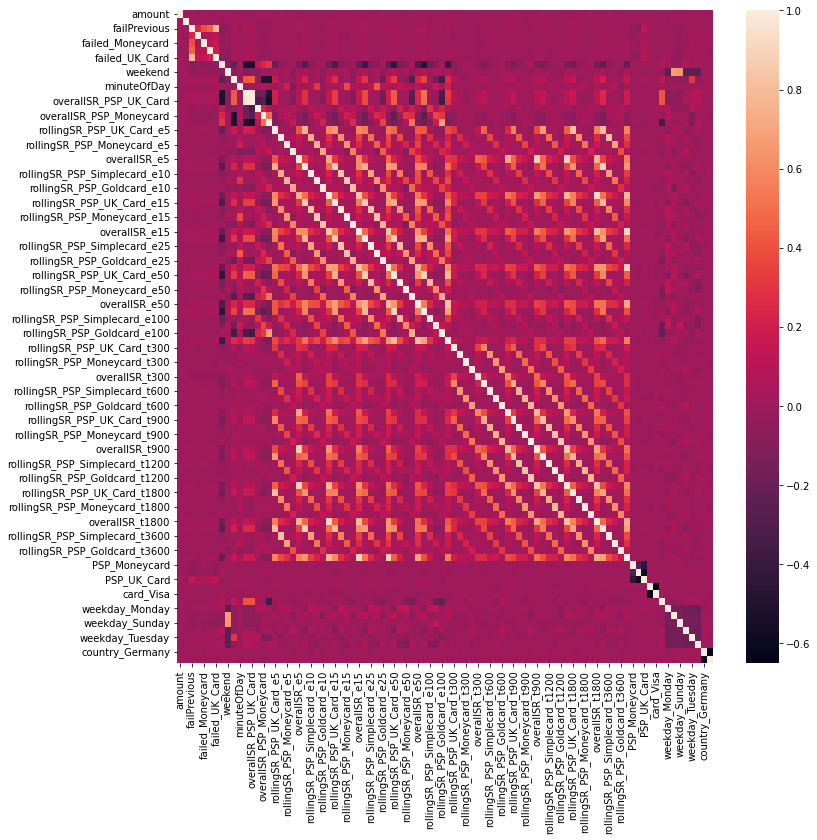

=== Highly correlated variables to drop ===
['rollingSR_PSP_UK_Card_e10', 'rollingSR_PSP_Simplecard_t1800', 'rollingSR_PSP_UK_Card_t1800', 'rollingSR_PSP_Goldcard_t1200', 'rollingSR_PSP_Simplecard_e5', 'rollingSR_PSP_Moneycard_e15', 'rollingSR_PSP_UK_Card_t900', 'rollingSR_PSP_UK_Card_e25', 'overallSR_e15', 'overallSR_t900', 'rollingSR_PSP_Simplecard_e25', 'rollingSR_PSP_Simplecard_t1200', 'rollingSR_PSP_Goldcard_e25', 'rollingSR_PSP_Simplecard_e15', 'failPrevious', 'overallSR_e25', 'overallSR_t3600', 'rollingSR_PSP_UK_Card_e50', 'overallSR_e50', 'rollingSR_PSP_UK_Card_t1200', 'rollingSR_PSP_Moneycard_t900', 'rollingSR_PSP_UK_Card_e5', 'rollingSR_PSP_Moneycard_t1200', 'rollingSR_PSP_Goldcard_e10', 'overallSR_t1800', 'overallSR_t1200', 'overallSR_PSP_UK_Card', 'rollingSR_PSP_Goldcard_e100', 'rollingSR_PSP_Simplecard_t900', 'overallSR_e5', 'rollingSR_PSP_UK_Card_t3600', 'rollingSR_PSP_Simplecard_e50', 'rollingSR_PSP_Simplecard_e10', 'overallSR_e10', 'rollingSR_PSP_Goldcard_t900', 'overal

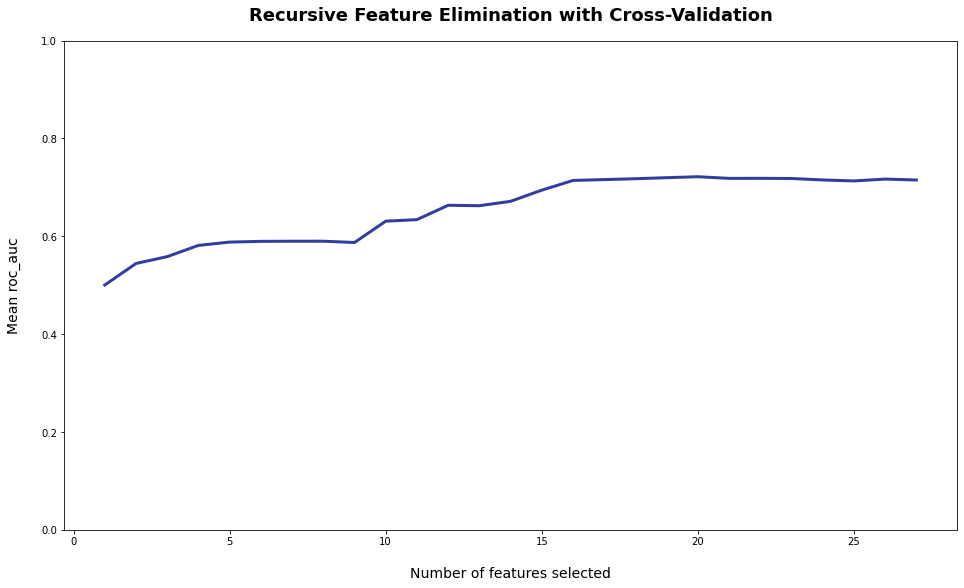

= Features:
['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR', 'overallSR_PSP_Simplecard', 'overallSR_PSP_Moneycard', 'overallSR_PSP_Goldcard', 'rollingSR_PSP_Moneycard_e5', 'rollingSR_PSP_Goldcard_e5', 'rollingSR_PSP_Goldcard_e15', 'rollingSR_PSP_Moneycard_e25', 'rollingSR_PSP_Moneycard_e50', 'rollingSR_PSP_Goldcard_e50', 'rollingSR_PSP_UK_Card_e100', 'rollingSR_PSP_Simplecard_e100', 'rollingSR_PSP_Moneycard_e100', 'rollingSR_PSP_UK_Card_t300', 'overallSR_t300', 'rollingSR_PSP_UK_Card_t600', 'rollingSR_PSP_Simplecard_t600', 'rollingSR_PSP_Moneycard_t600', 'overallSR_t600', 'rollingSR_PSP_Moneycard_t1800', 'rollingSR_PSP_Goldcard_t1800', 'rollingSR_PSP_Simplecard_t3600', 'rollingSR_PSP_Moneycard_t3600', 'rollingSR_PSP_Goldcard_t3600', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa', 'country_Germany', 'country_Switzerland']
= Maximum Test Score:
0.7216653663151814
=== rfecv_roc_auc s

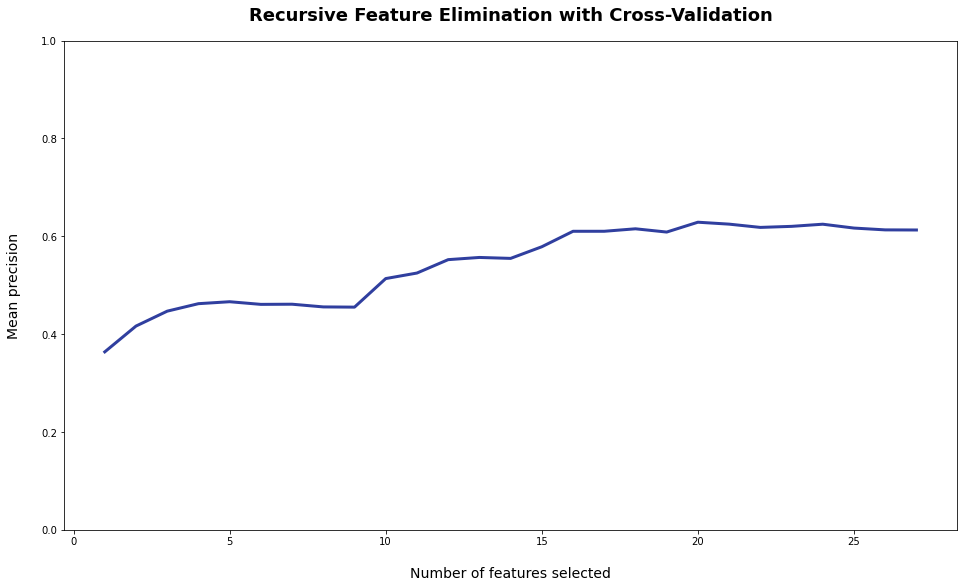

= Features:
['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR', 'overallSR_PSP_Simplecard', 'overallSR_PSP_Moneycard', 'overallSR_PSP_Goldcard', 'rollingSR_PSP_Moneycard_e5', 'rollingSR_PSP_Goldcard_e5', 'rollingSR_PSP_Goldcard_e15', 'rollingSR_PSP_Moneycard_e25', 'rollingSR_PSP_Moneycard_e50', 'rollingSR_PSP_Goldcard_e50', 'rollingSR_PSP_UK_Card_e100', 'rollingSR_PSP_Simplecard_e100', 'rollingSR_PSP_Moneycard_e100', 'rollingSR_PSP_UK_Card_t300', 'overallSR_t300', 'rollingSR_PSP_UK_Card_t600', 'rollingSR_PSP_Simplecard_t600', 'rollingSR_PSP_Moneycard_t600', 'overallSR_t600', 'rollingSR_PSP_Moneycard_t1800', 'rollingSR_PSP_Goldcard_t1800', 'rollingSR_PSP_Simplecard_t3600', 'rollingSR_PSP_Moneycard_t3600', 'rollingSR_PSP_Goldcard_t3600', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa', 'country_Germany', 'country_Switzerland']
= Maximum Test Score:
0.6287037037037037
=== rfecv_precision

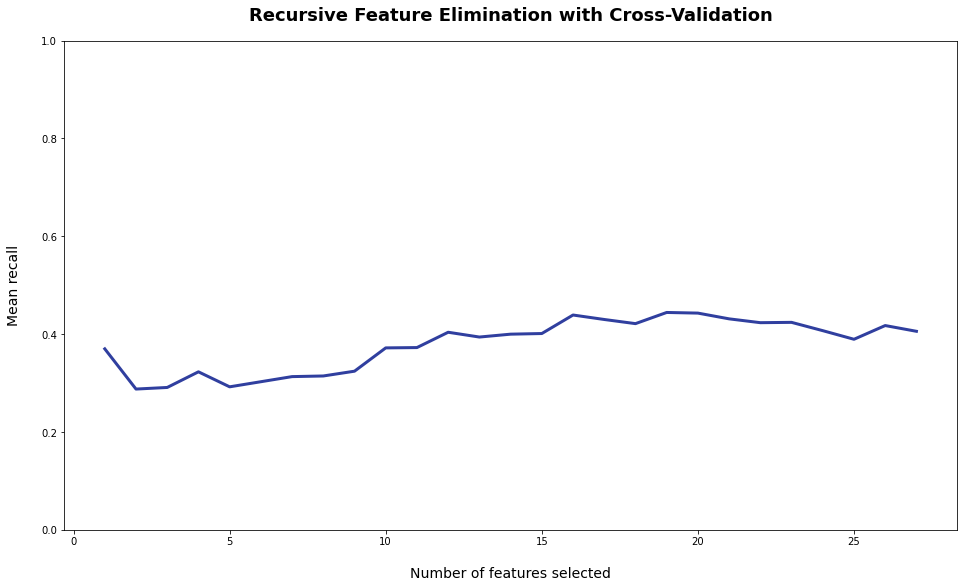

= Features:
['amount', '3D_secured', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'overallSR', 'overallSR_PSP_Simplecard', 'overallSR_PSP_Moneycard', 'overallSR_PSP_Goldcard', 'rollingSR_PSP_Moneycard_e5', 'rollingSR_PSP_Goldcard_e5', 'rollingSR_PSP_Goldcard_e15', 'rollingSR_PSP_Moneycard_e25', 'rollingSR_PSP_Moneycard_e50', 'rollingSR_PSP_Goldcard_e50', 'rollingSR_PSP_UK_Card_e100', 'rollingSR_PSP_Simplecard_e100', 'rollingSR_PSP_Moneycard_e100', 'rollingSR_PSP_UK_Card_t300', 'overallSR_t300', 'rollingSR_PSP_UK_Card_t600', 'rollingSR_PSP_Simplecard_t600', 'overallSR_t600', 'rollingSR_PSP_Moneycard_t1800', 'rollingSR_PSP_Goldcard_t1800', 'rollingSR_PSP_Simplecard_t3600', 'rollingSR_PSP_Moneycard_t3600', 'rollingSR_PSP_Goldcard_t3600', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa', 'country_Germany', 'country_Switzerland']
= Maximum Test Score:
0.44422700587084146
=== rfecv_recall saved to pickle file ===

=== Most important features

In [22]:
try:
    applyFeatureSelection(metrics = ["roc_auc", "precision", "recall"], 
                          correlation_threshold = 0.7,
                          estimator = RandomForestClassifier(n_estimators=500, random_state=1977),
                          figsize = 12
                         )
except:
    print("=== There is a serious error in the pipeline ===")

# References

<p>Bygari, R., Gupta, A., Raghuvanshi, S., Bapna, A., & Sahu, B. (2021). An AI-powered Smart Routing Solution for Payment Systems. 2026–2033. https://doi.org/10.1109/BigData52589.2021.9671961 </p>
<p>IBM Corporation. (2021). IBM Documentation: IBM SPSS Modeler CRISP-DM Guide.     https://www.ibm.com/docs/en/spss-modeler/18.1.1?topic=spss-modeler-crisp-dm-guide </p>
<p>Kuhn, M., & Johnson, K. (2013). Applied Predictive Modeling (1st ed. 2013, Corr. 2nd printing 2018 Edition). Springer.</p>
<p>Kuhn, M., & Johnson, K. (2019). Feature Engineering and Selection: A Practical Approach for Predictive Models. Taylor & Francis Ltd. http://www.feat.engineering/</p>
<p>Wirth, R., & Hipp, J. (2000). CRISP-DM: Towards a standard process model for data mining. Proceedings of the 4th International Conference on the Practical Applications of Knowledge Discovery and Data Mining.</p>